# Metric Learning

## Train

In [1]:
import os
import os.path
import sys
from IPython.display import clear_output
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

import torch, torchvision
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import Sampler
print("PyTorch Version - %s" % torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current Device - %s" % device)
if torch.cuda.is_available():
    print("CUDA Device Count - %s" % torch.cuda.device_count())
    print("CUDA Device Name - %s" % torch.cuda.get_device_name())
    print("CUDA Device Memory - %0.2f GB"%(float(torch.cuda.get_device_properties(0).total_memory)/1024**3))

PyTorch Version - 1.2.0
Current Device - cuda:0
CUDA Device Count - 1
CUDA Device Name - GeForce GTX 1080 Ti
CUDA Device Memory - 10.92 GB


In [2]:
from data_util.custom_dataset import FramePairsDataset
from data_util.custom_sampler import VideoFrameSampler
import data_util.simclr_transforms as simclr_transforms


train_dir = '../data/mnist_png/training'
val_dir = '../data/mnist_png/testing'

#Number of (anchor, positive) sample pairs in each N-Pair Loss computation
num_pairs = 10
#Number of (anchor, positive) sample pairs to take from each video in one epoch
passes_per_epoch = 300 
#Max frames per video/class
max_frames = 5000 


simclr_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    #simclr_transforms.get_color_distortion(s=0.5),
    simclr_transforms.RandomGaussianBluring(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = FramePairsDataset(train_dir, '.png', distance=20, transform=simclr_transforms)
sampler = VideoFrameSampler(range(10), passes_per_epoch, max_frames)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=num_pairs, sampler=sampler, drop_last=True)

val_dataset = FramePairsDataset(val_dir, '.png', distance=20, transform=simclr_transforms)
val_sampler = VideoFrameSampler(range(10), 10, max_frames)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=num_pairs, sampler=val_sampler, drop_last=True)

torch.Size([10, 1, 28, 28])


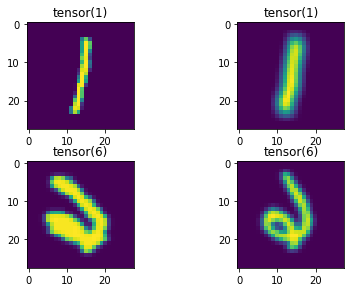

In [3]:
def test_data_loader(data_loader):
    anchors, positives, labels = iter(data_loader).next()
    print(anchors.shape)
    anchors = anchors.permute(0,2,3,1).squeeze(-1)
    positives = positives.permute(0,2,3,1).squeeze(-1)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()
    ax1.set_title(str(labels[0]))
    ax1.imshow(anchors[0])
    ax2.set_title(str(labels[0]))
    ax2.imshow(positives[0])
    ax3.set_title(str(labels[1]))
    ax3.imshow(anchors[1])
    ax4.set_title(str(labels[1]))
    ax4.imshow(positives[1])
    

test_data_loader(data_loader)

#### Model and Optimizer

In [4]:
from model.mnist_model import MNISTNet
from loss.npair_loss import NPairLoss

z_dim = 3
model = MNISTNet(z_dim=z_dim)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) #use model.module.parameters() if using multiple GPUs
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5)
criterion = NPairLoss(device, num_pairs, .001)

#### Training the Network

In [5]:
def train(epoch):
    model.train()
    count = 0
    running_loss = 0.0
    lr = optimizer.param_groups[0]['lr']
    for batch_frames in data_loader:
        count += 1
        optimizer.zero_grad()
        anchors = batch_frames[0]
        positives = batch_frames[1]
        anchors, positives = anchors.to(device), positives.to(device)
        r_anchors, r_positives = model(anchors), model(positives)
        loss, accuracy = criterion(r_anchors, r_positives)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %3d | Avg Loss: %f | LR : %.9f" 
          % (epoch, running_loss/count, lr))
    return running_loss


def validation():
    scheduler.step()
    model.eval()
    accuracy = 0.0
    count = 0
    for batch_frames in val_loader:
        count += 1
        with torch.no_grad():
            anchors = batch_frames[0]
            positives = batch_frames[1]
            anchors, positives = anchors.to(device), positives.to(device)
            r_anchors, r_positives = model(anchors), model(positives)
            loss, acc = criterion(r_anchors, r_positives)
            accuracy += acc
    return (accuracy*100.)/count

In [6]:
epochs = 15
max_accuracy = 0
train_losses = []
test_accuracies = []
file_name = '{}_{}d.pth'.format(type(model).__name__, z_dim)
PATH = './pth_files/{}'.format(file_name)

for epoch in range(1, epochs+1):
    train_losses.append(train(epoch))
    accuracy = validation()
    test_accuracies.append(accuracy)
    print("Accuracy = %f" %(accuracy))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        print("Saving model to %s. Accuracy = %f." %(file_name, accuracy))
        torch.save(model.state_dict(), PATH) #model.module.state_dict() if using multiple GPUs

Epoch:   1 | Avg Loss: 2.230248 | LR : 0.001000000
Accuracy = 39.500000
Saving model to MNISTNet_3d.pth. Accuracy = 39.500000.
Epoch:   2 | Avg Loss: 1.797541 | LR : 0.001000000
Accuracy = 51.000004
Saving model to MNISTNet_3d.pth. Accuracy = 51.000004.
Epoch:   3 | Avg Loss: 1.520183 | LR : 0.001000000
Accuracy = 56.499992
Saving model to MNISTNet_3d.pth. Accuracy = 56.499992.
Epoch:   4 | Avg Loss: 1.287093 | LR : 0.001000000
Accuracy = 70.500015
Saving model to MNISTNet_3d.pth. Accuracy = 70.500015.
Epoch:   5 | Avg Loss: 1.151104 | LR : 0.001000000
Accuracy = 70.500000
Epoch:   6 | Avg Loss: 1.052008 | LR : 0.001000000
Accuracy = 76.000000
Saving model to MNISTNet_3d.pth. Accuracy = 76.000000.
Epoch:   7 | Avg Loss: 0.909221 | LR : 0.001000000
Accuracy = 77.499992
Saving model to MNISTNet_3d.pth. Accuracy = 77.499992.
Epoch:   8 | Avg Loss: 0.890162 | LR : 0.001000000
Accuracy = 80.499992
Saving model to MNISTNet_3d.pth. Accuracy = 80.499992.
Epoch:   9 | Avg Loss: 0.763202 | LR : 

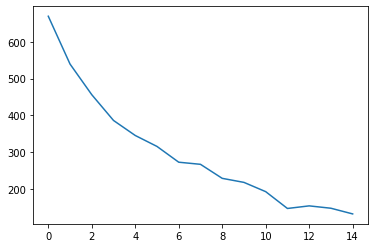

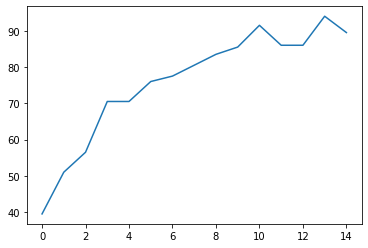

In [7]:
plt.plot(train_losses)
plt.show()
plt.plot(test_accuracies)
plt.show()

## Visualize

#### Loading State Dict

In [8]:
file_name = '{}_{}d.pth'.format(type(model).__name__, z_dim)
PATH = './pth_files/{}'.format(file_name)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict)

<All keys matched successfully>

#### Forward Pass

In [9]:
batch_size = 1000
data_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

anchors, positives, labels = iter(data_loader).next()
samples = torch.cat((anchors, positives), dim=0)
labels = torch.cat((labels, labels), dim=0)
#print(samples.shape)
#print(labels.shape)

samples = samples.to(device)
rep = model(samples)
rep = rep.cpu().detach()

#### PCA

In [10]:
from sklearn.decomposition import PCA

np_rep = rep.numpy()
pca = PCA()
pca.fit(np_rep)
pca.explained_variance_ratio_ #.93,.06,

array([0.9130686 , 0.05284441, 0.03408695], dtype=float32)

#### Visualize-3D

<IPython.core.display.Javascript object>


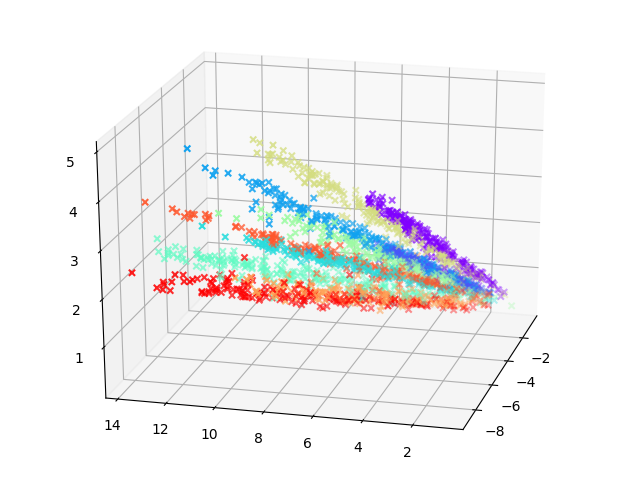

In [11]:
if z_dim == 3:
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D

    X = rep[:, 0]
    Y = rep[:, 1]
    Z = rep[:, 2]

    #3D Graph
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(X, Y, Z, c=labels, marker="x", cmap='rainbow')
    plt.show()

<IPython.core.display.Javascript object>


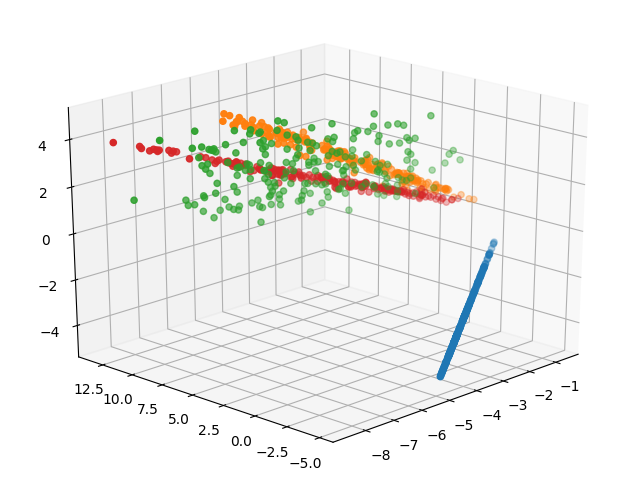

In [12]:
if z_dim == 3:
    %matplotlib notebook
    masks = [labels == i for i in range(10)]
    colors = ['r', 'b', 'g', 'y']


    rep0 = rep[masks[0]]
    X0 = rep0[:,0]
    Y0 = rep0[:,1]
    Z0 = rep0[:,2]

    rep6 = rep[masks[6]]
    X6 = rep6[:,0]
    Y6 = rep6[:,1]
    Z6 = rep6[:,2]

    rep8 = rep[masks[8]]
    X8 = rep8[:,0]
    Y8 = rep8[:,1]
    Z8 = rep8[:,2]

    rep3 = rep[masks[3]]
    X3 = rep3[:,0]
    Y3 = rep3[:,1]
    Z3 = rep3[:,2]

    #3D Graphs
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X0, X0, X0, cmap=colors[0])
    ax.scatter(X6, Y6, Z6, cmap=colors[1])
    ax.scatter(X3, Y3, Z6, cmap=colors[2])
    ax.scatter(X8, Y8, Z8, cmap=colors[3])
    plt.show()

#### Visualize-2D

In [ ]:
if z_dim == 2:
    X = rep[:, 0]
    Y = rep[:, 1]

    #2D Graph
    plt.scatter(X, Y, c=labels, cmap='rainbow')
    plt.show()

In [ ]:
if z_dim == 2:
    colors = ['r', 'b', 'g', 'y']
    masks = [labels == i for i in range(10)]
    rep_T = rep.T


    nums = [0, 8, 3]
    for idx, num in enumerate(nums):
        num_coors = [rep_T[i][masks[num]] for i in range(z_dim)]
        plt.scatter(num_coors[0], num_coors[1], cmap=colors[idx])

    plt.show()